In [1]:
import numpy as np
import torch
import tensorflow as tf
import gym
import sys
from collections import deque
import random

In [2]:
from explorerl.utils import *
from explorerl.agents import *

## DQN Tensorflow

In [3]:
env = gym.make('CartPole-v0')

In [4]:
class DQN(tf.keras.Model):
    def __init__(self,input_space,output_space,batch_norm=False):
        super(DQN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=24,input_shape=(input_space,))
        self.dense2 = tf.keras.layers.Dense(units=24)
        self.dense3 = tf.keras.layers.Dense(units=output_space)

    def call(self,x,training=True):
        x = tf.nn.relu(self.dense1(x))
        x = tf.nn.relu(self.dense2(x))
        x = self.dense3(x)
        return x

In [5]:
e = Env_Wrapper(env)

In [6]:
class DQNTF(BaseAgent):
    def __init__(self,epsilon=1.0, decay= 0.995, gamma=.95, 
                 learning_rate=0.0001, featurizer=None,scaler=None,use_bias = False,has_replay=True,
                 replay_size=2000,replay_batch=32):
        super(DQNTF, self).__init__(gamma, 
                 learning_rate, featurizer,scaler,use_bias,has_replay)
        tf.keras.backend.clear_session()
        self.name = "DQNTF"
        self.epsilon = epsilon
        self.decay = decay
        self.experience_replay = deque(maxlen=replay_size)
        self.replay_batch = replay_batch
        self.original_configs = {"epsilon":self.epsilon,"decay":self.decay}
    
    def initialize_replay(self,env):
        c = 0
        while c < self.experience_replay.maxlen:
            obs = env.reset()
            while True:
                action = env.action_space.sample()
                next_obs, reward, done, info = env.step(action)
                self.save_replay(self.featurize_state(obs),action,self.featurize_state(next_obs),reward,done)
                c += 1
                if done:
                    break
            
    def save_replay(self,obs,action,next_obs,reward,done):
        self.experience_replay.append([obs,action,next_obs,reward,done])
        
    def initialize_model(self,observation_space,action_space):
        self.epsilon = self.original_configs["epsilon"]
        self.decay = self.original_configs["decay"]
        self.observation_space = observation_space[0]
        self.action_space = action_space
        input_space = self.observation_space  
        if self.featurizer:
            input_space = self.featurizer.transform([np.ones(self.observation_space)]).flatten().shape[0]
        if self.use_bias:
            input_space += 1
        
        model = FeedForwardNN(input_space,self.action_space)
        def mse_loss(model,predictions,targets):
            return tf.reduce_mean(tf.square(tf.subtract(predictions,targets)))
#             return tf.reduce_mean(tf.square(tf.subtract(predictions,targets))) + tf.add_n(model.losses)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model["outputs"] = model
        
        def train_step(model,inputs,targets):
            with tf.GradientTape() as tape:
                predictions = model(inputs)
                total_loss = mse_loss(model,predictions,tf.stop_gradient(targets))
            gradients = tape.gradient(total_loss,model.trainable_variables)
            optimizer.apply_gradients(zip(gradients,model.trainable_variables))
                
        self.model["loss"] = mse_loss
        self.model["training_op"] = train_step
        print("Model Created!")
    
    def update_hyper_params(self,episode):
        self.epsilon *= (self.decay**episode)
        
    def train_policy(self):
        return self.epsilon_greedy()
    
    def test_policy(self):
        return self.greedy()
    
    def epsilon_greedy(self):
        def act(obs):
            qvals = self.model["outputs"](obs)
            if np.random.random() < self.epsilon:
                return np.random.choice(self.action_space) , qvals
            return np.argmax(qvals[0]) , qvals
        return act
                
    def greedy(self):
        def act(obs):
            qvals = self.model["outputs"](obs)
            return np.argmax(qvals[0]) , qvals
        return act
    
    def replay(self,training_op,policy):
        minibatch = random.sample(self.experience_replay, self.replay_batch)
        obs_arr = []
        targets = []
        for obs, action, next_obs, reward, done in minibatch:
            reward = reward if not done else -10
            target = reward
            obs_arr.append(obs)
            if not done:
                next_qvals = self.model["outputs"](next_obs)
                target = (reward + self.gamma * np.max(np.array(next_qvals)))
            qvals =  self.model["outputs"](obs)
            target_f = np.array(qvals)
            target_f[0][action] = target
            target_f = tf.stop_gradient(target_f)
            training_op(self.model["outputs"],obs,target_f)
            targets.append(target_f)
        obs_arr = np.array(obs_arr)
        targets = np.array(targets)
        return np.array(obs_arr),np.array(tf.stop_gradient(targets))
    
    def episodal_train_iter(self,policy):
        training_op = self.model["training_op"]
        model = self.model["outputs"]
        obs, targets = self.get_replay(training_op,policy)
        _, outs = policy(obs)
#         training_op(self.model["outputs"],obs,targets)
        
    def train_iter(self,policy,action,values,obs,next_obs,reward,done):
        training_op = self.model["training_op"]
        self.save_replay(obs,action,next_obs,reward,done)
        obs, targets = self.replay(training_op,policy)
#         training_op(self.model["outputs"],obs,targets)
    
    def train(self,env,episodes=200,early_stop=False,stop_criteria=20):
        prev_avg = -float('inf')
        orig_epsilon = self.epsilon
        bar = tqdm(np.arange(episodes),file=sys.stdout)
        policy = self.epsilon_greedy()
        criteria = 0 #stopping condition
        training_op = self.model["training_op"]
        for i in bar:
            observation = env.reset()
            self.epsilon *= (self.decay**i)
            rewards = 0
            end = 0
            observation = self.featurize_state(observation)
            for t in range(10000):
                action , qvals = policy(observation)
                next_obs, reward, done, info = env.step(action)
                rewards += reward
                next_obs = self.featurize_state(next_obs)
                next_action , next_qs = policy(next_obs)
                target = reward + self.gamma*np.max(next_qs[0])
                inp = self.featurize_state(observation)
                training_op(self.model["outputs"],inp,tf.stop_gradient(target))
                end = t
                if done:
                    break
                observation = next_obs
                
            self.stats["num_steps"].append(end)
            self.stats["episodes"].append(i)
            self.stats["rewards"].append(rewards)
            avg = np.mean(self.stats["rewards"][::-1][:25])
            bar.set_description("Epsilon and Num Steps {} : {}".format(self.epsilon,end))
            
            if avg < prev_avg:
                criteria += 1
                
            if early_stop:
                if criteria >= stop_criteria:
                    break
                    
            prev_avg = avg
        return self.stats

In [7]:
d = DQNTF2()

  0%|          | 0/100 [00:00<?, ?it/s]

Model Created!


Epsilon : 1.6759061371261904e-11, Num Steps : 199, Avg Reward with Window Size 25 : 179.4: 100%|██████████| 100/100 [29:43<00:00, 17.83s/it]        
/Users/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/shyam/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


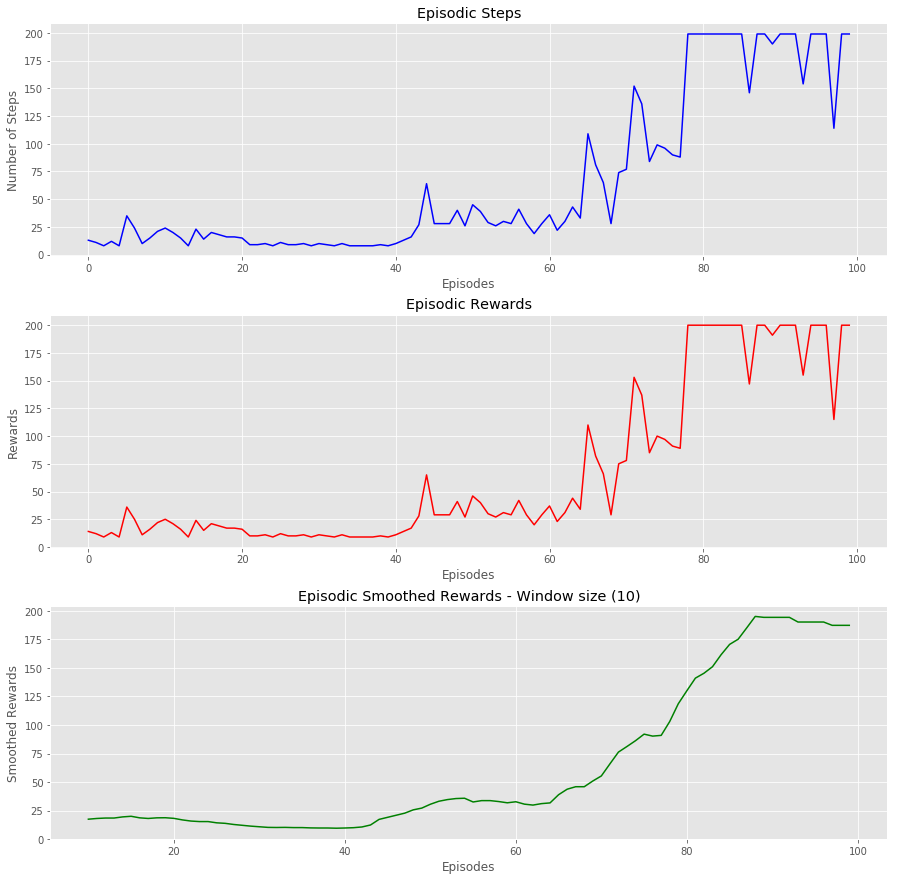

{'rewards': [14.0,
  12.0,
  9.0,
  13.0,
  9.0,
  36.0,
  25.0,
  11.0,
  16.0,
  22.0,
  25.0,
  21.0,
  16.0,
  9.0,
  24.0,
  15.0,
  21.0,
  19.0,
  17.0,
  17.0,
  16.0,
  10.0,
  10.0,
  11.0,
  9.0,
  12.0,
  10.0,
  10.0,
  11.0,
  9.0,
  11.0,
  10.0,
  9.0,
  11.0,
  9.0,
  9.0,
  9.0,
  9.0,
  10.0,
  9.0,
  11.0,
  14.0,
  17.0,
  28.0,
  65.0,
  29.0,
  29.0,
  29.0,
  41.0,
  27.0,
  46.0,
  40.0,
  30.0,
  27.0,
  31.0,
  29.0,
  42.0,
  29.0,
  20.0,
  29.0,
  37.0,
  23.0,
  31.0,
  44.0,
  34.0,
  110.0,
  82.0,
  66.0,
  29.0,
  75.0,
  78.0,
  153.0,
  137.0,
  85.0,
  100.0,
  97.0,
  91.0,
  89.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  200.0,
  147.0,
  200.0,
  200.0,
  191.0,
  200.0,
  200.0,
  200.0,
  155.0,
  200.0,
  200.0,
  200.0,
  115.0,
  200.0,
  200.0],
 'episodes': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  2

In [8]:
e.train(d,episodes=100,train_episodal=False)


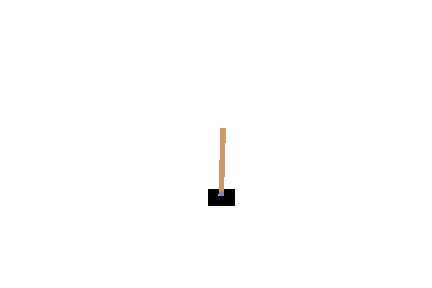
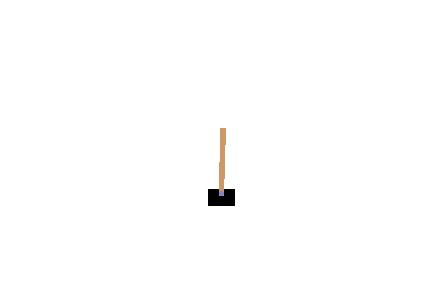
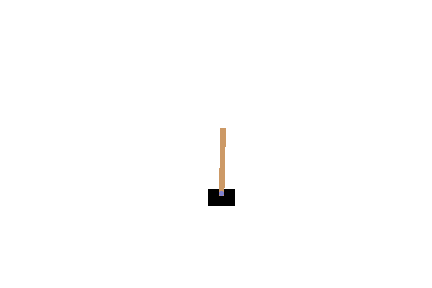
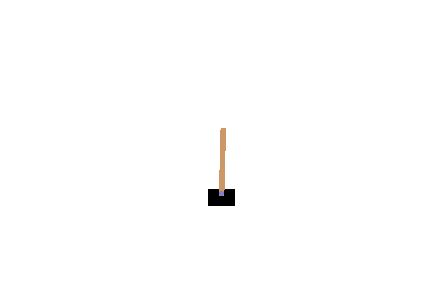
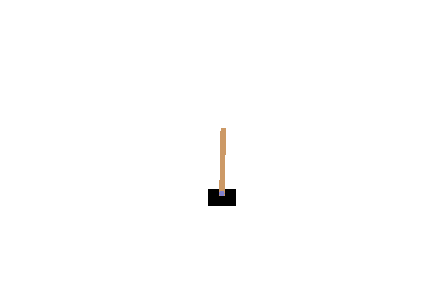
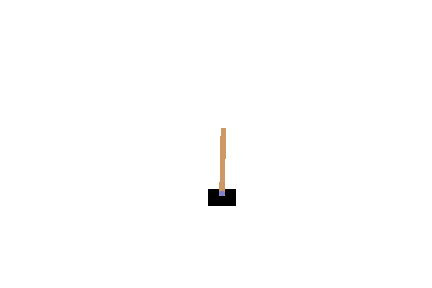
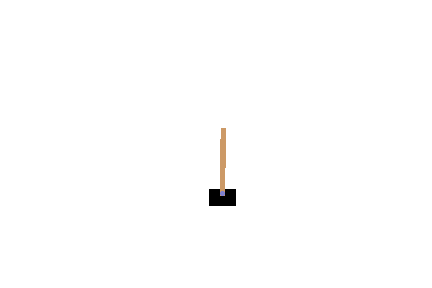
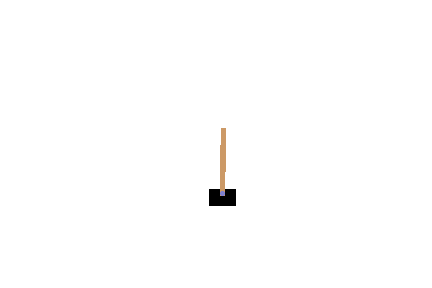
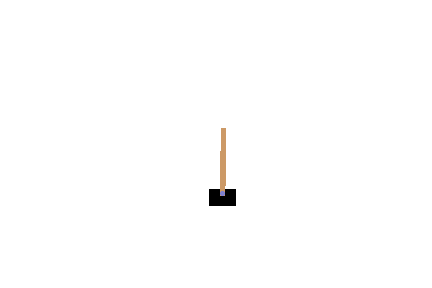
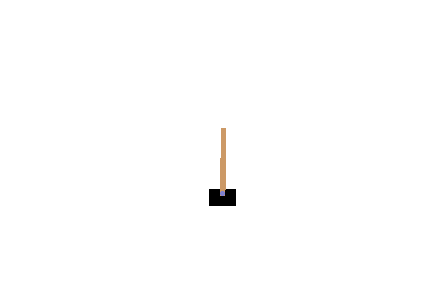
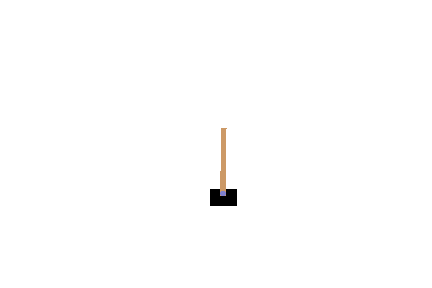
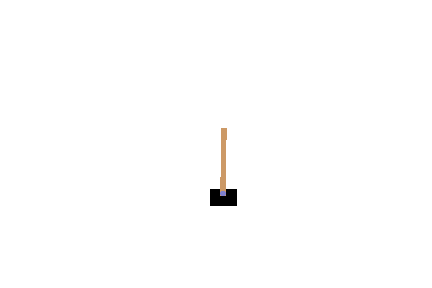
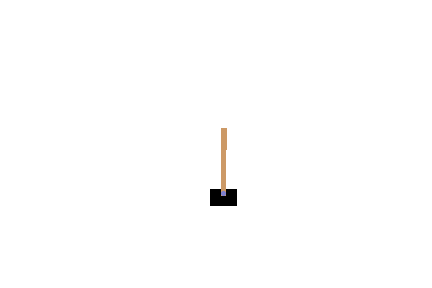
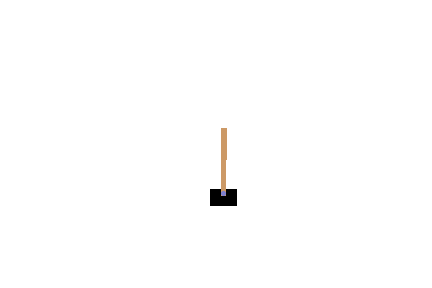
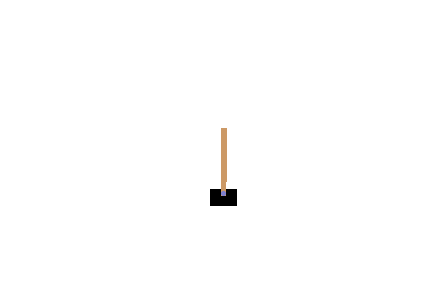
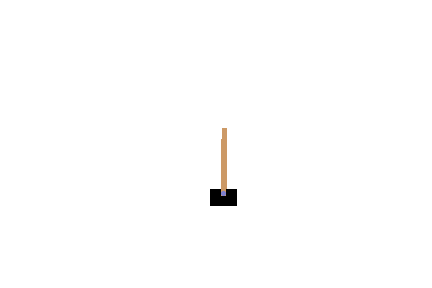
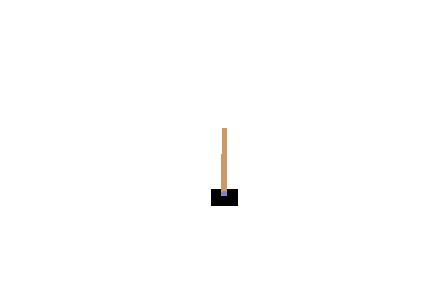
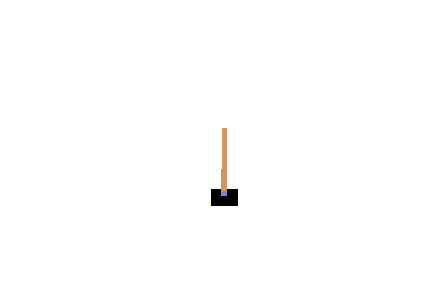
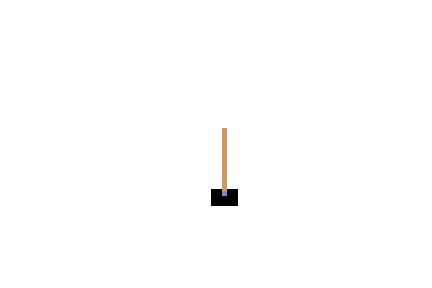
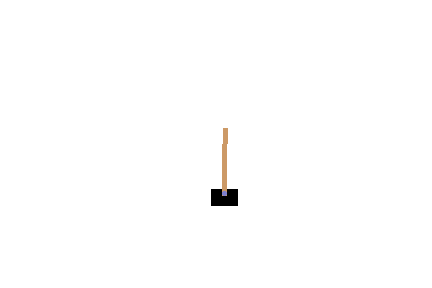
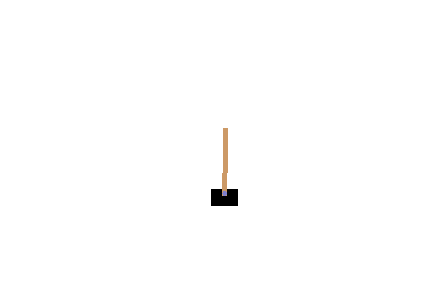
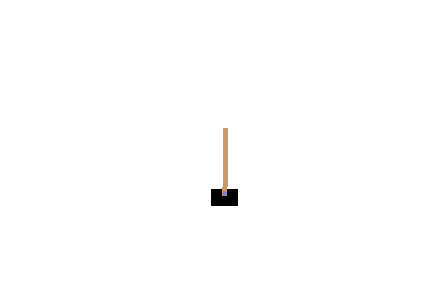
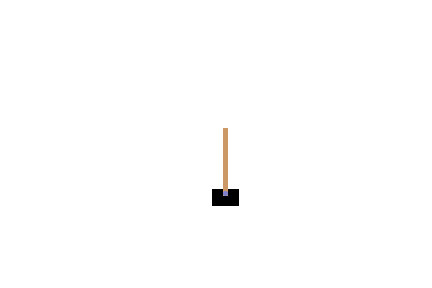
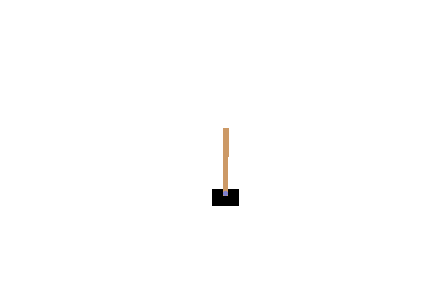
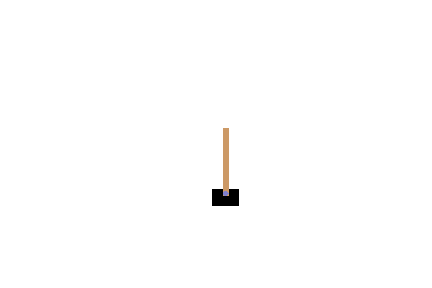
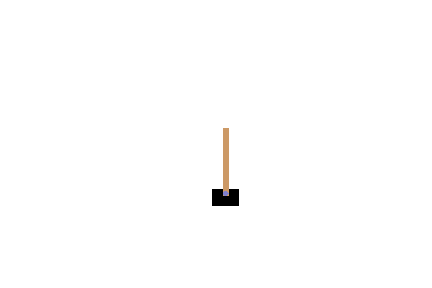
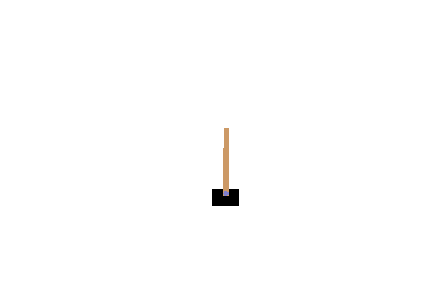
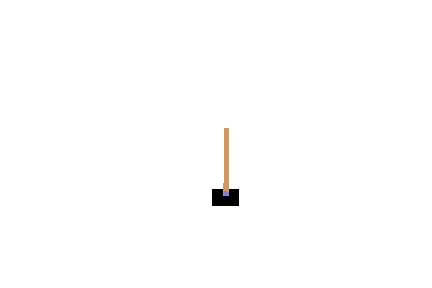
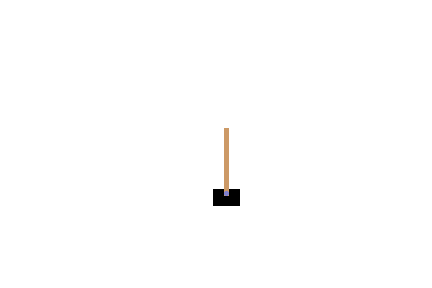
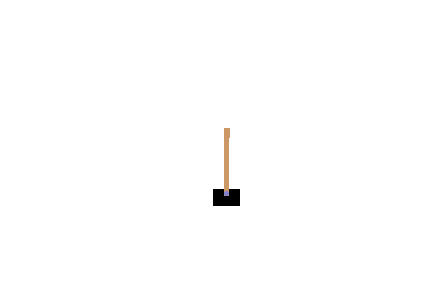
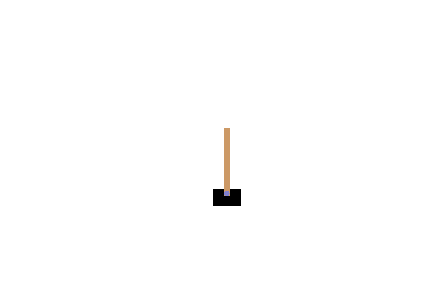
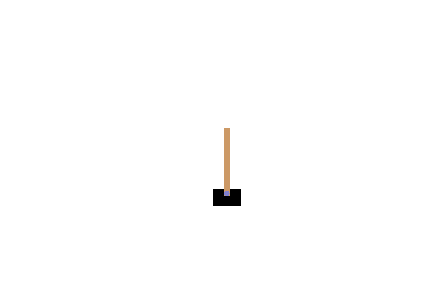
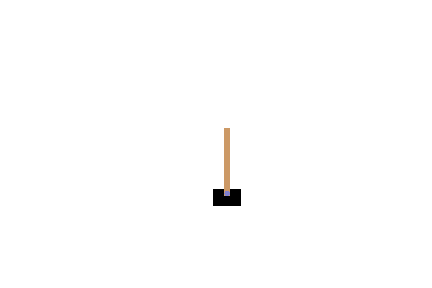
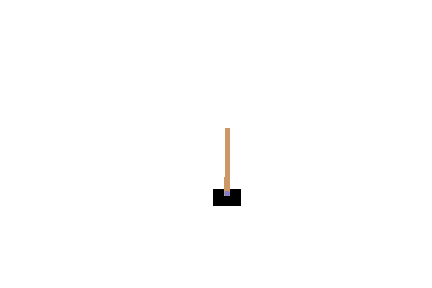
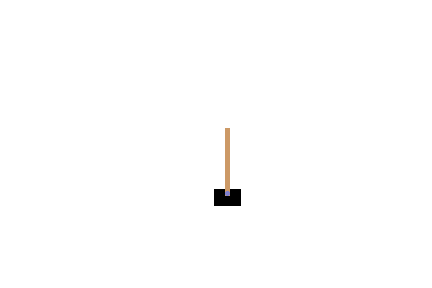
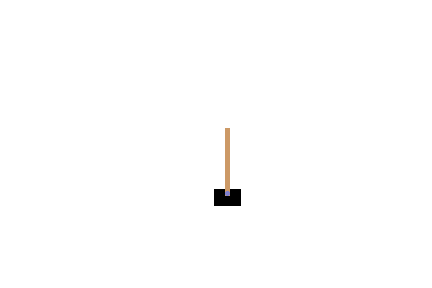
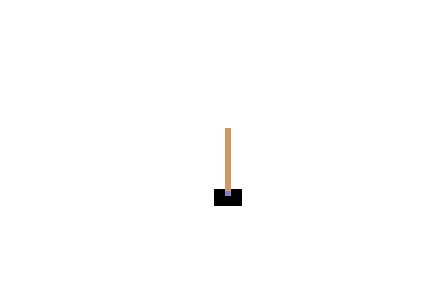
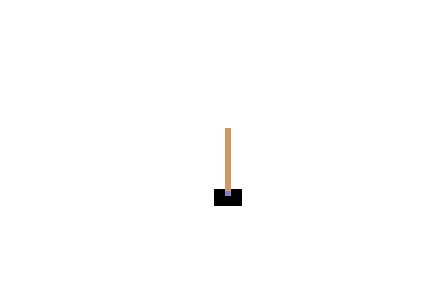
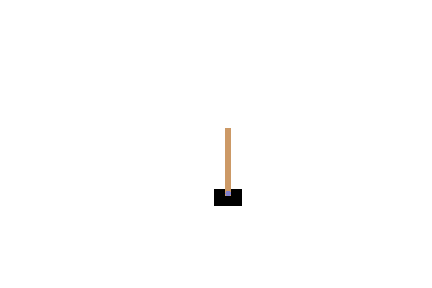
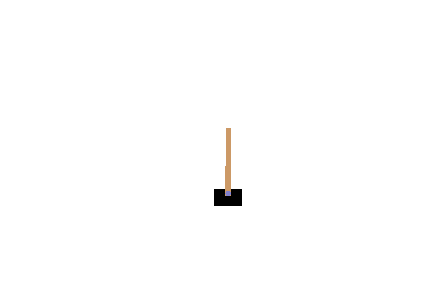
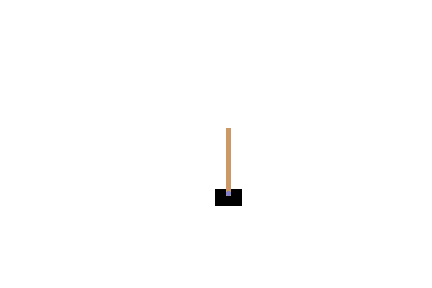
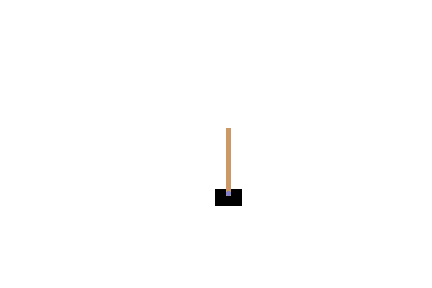
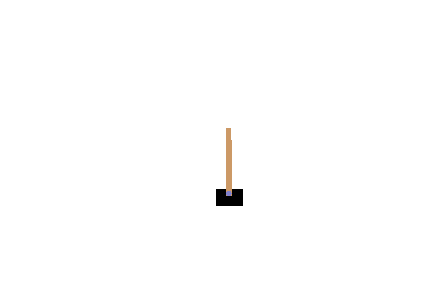
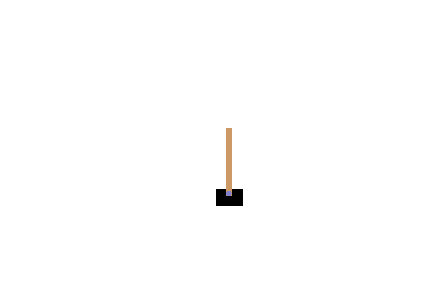
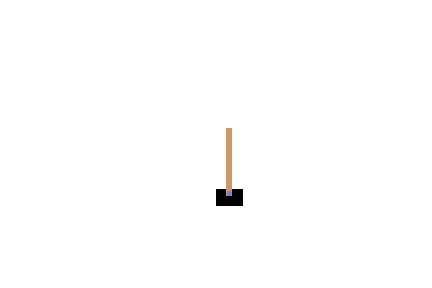
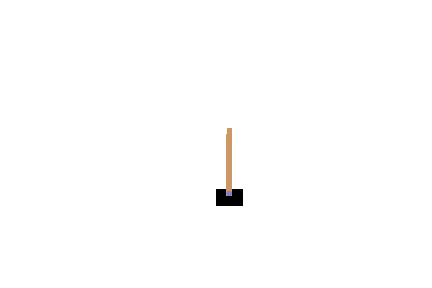
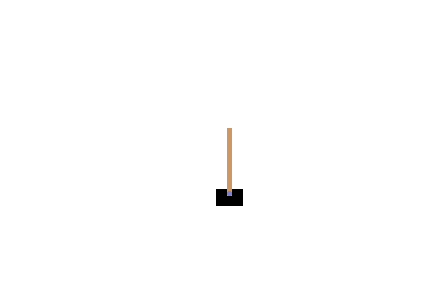
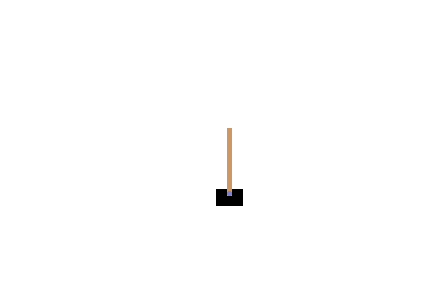
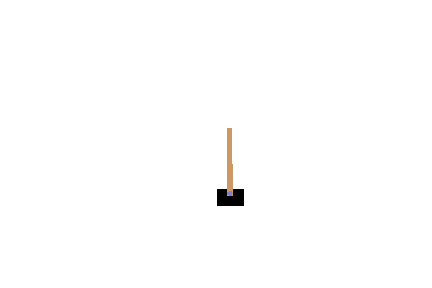
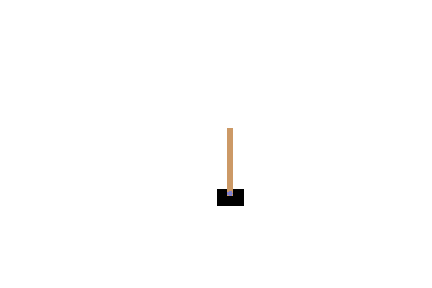
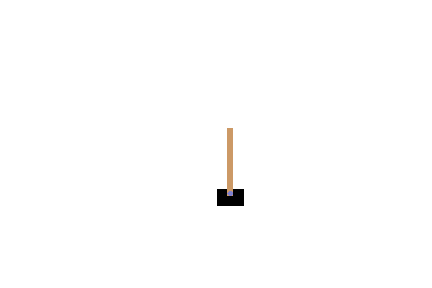
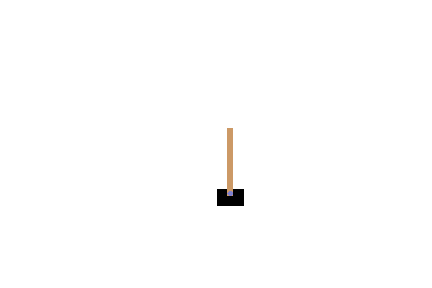
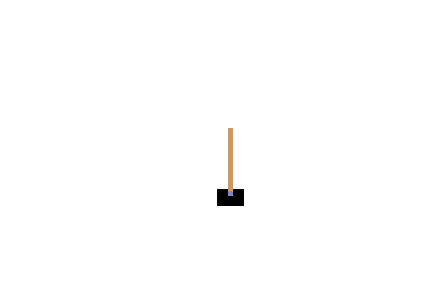
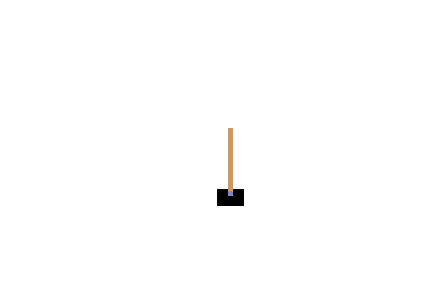
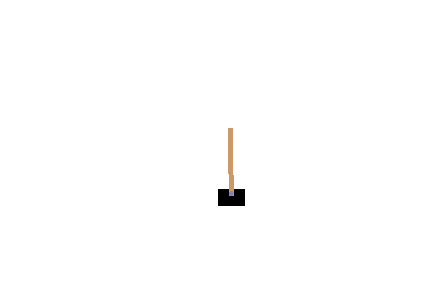
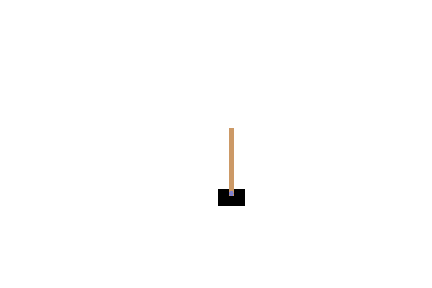
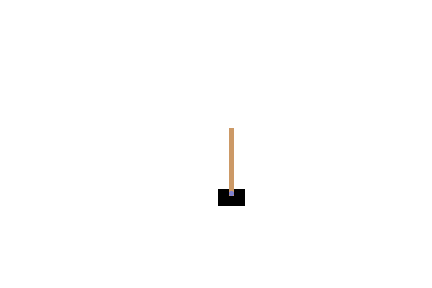
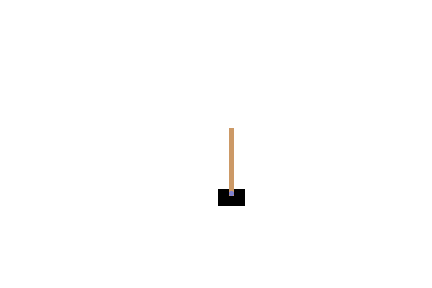
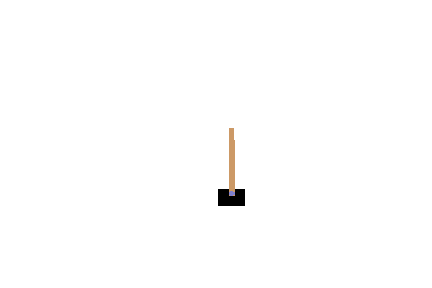
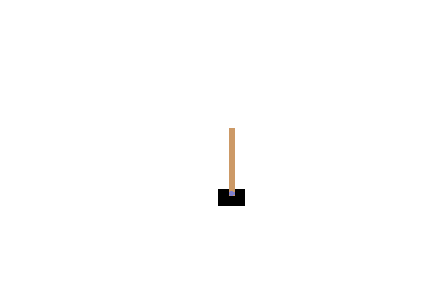
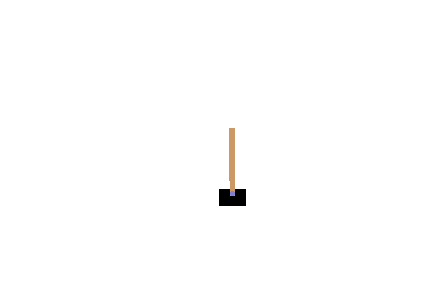
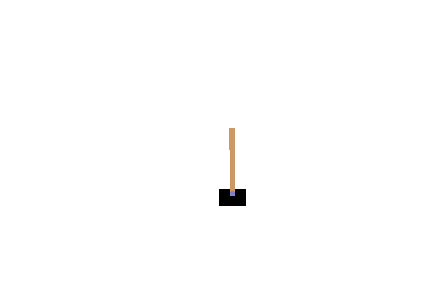
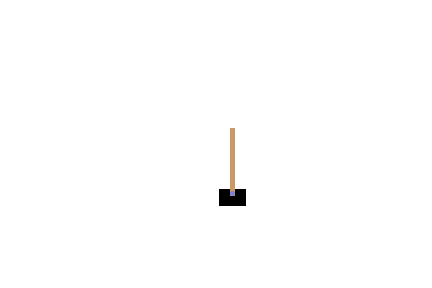
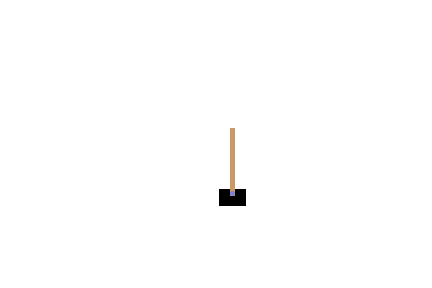
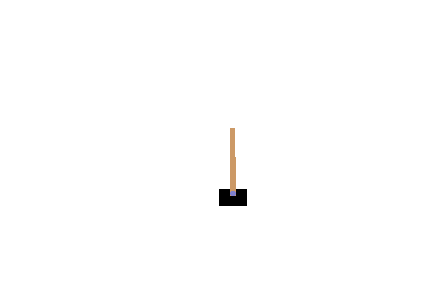
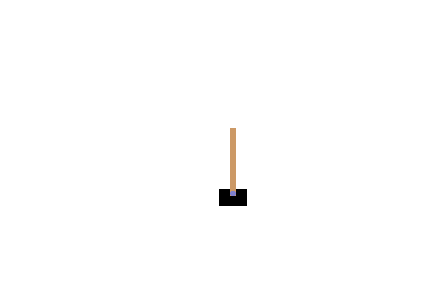
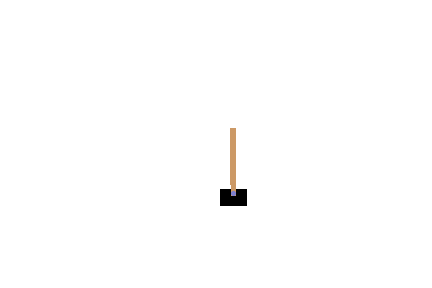
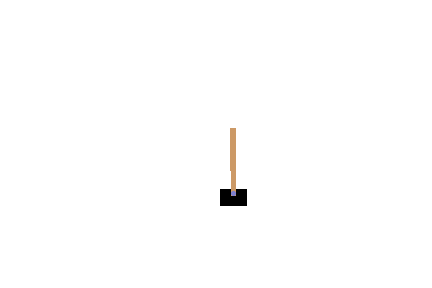
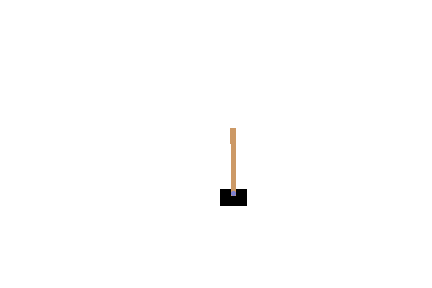
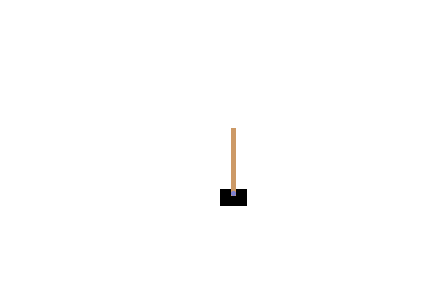
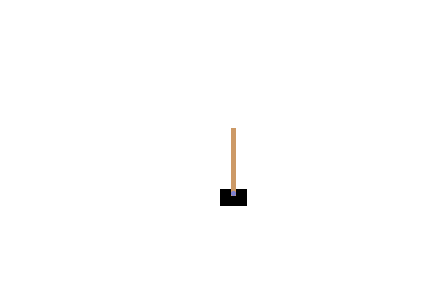
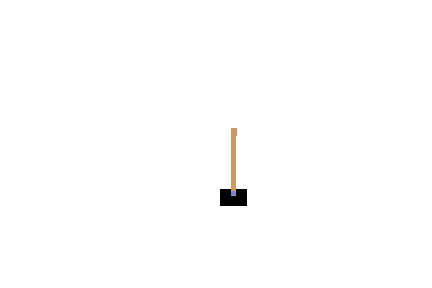
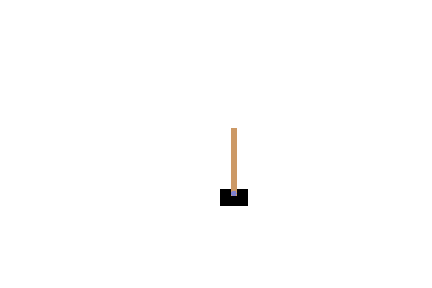
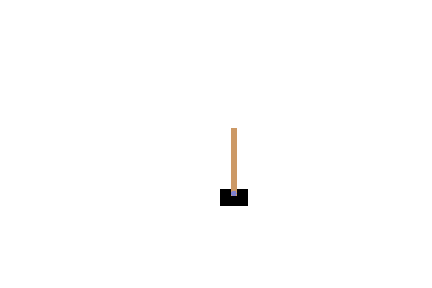
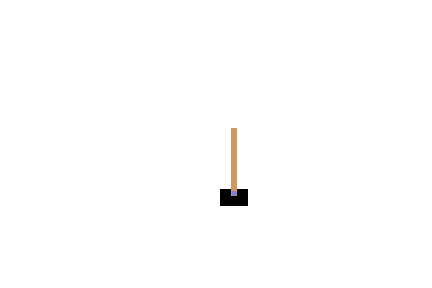
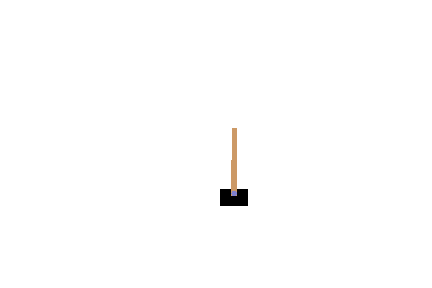
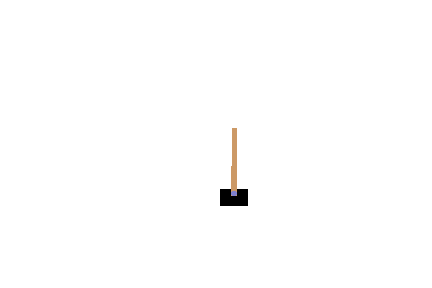
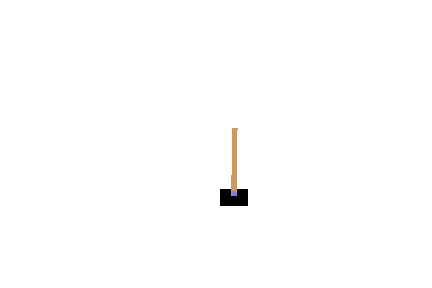
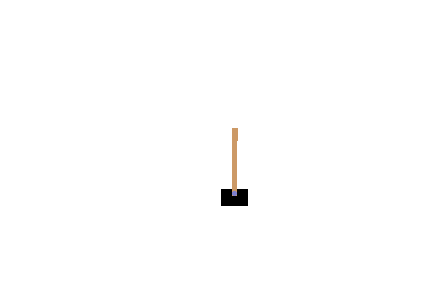
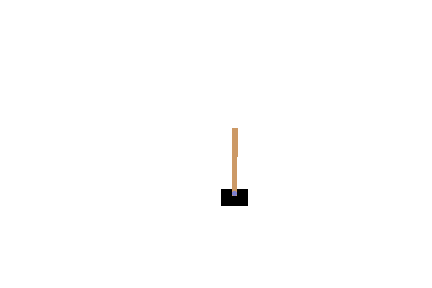
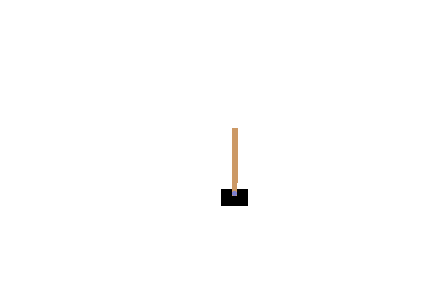
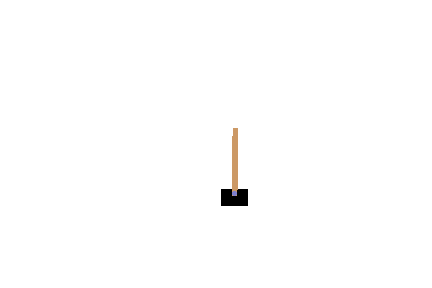
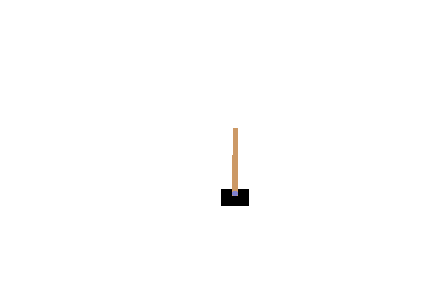
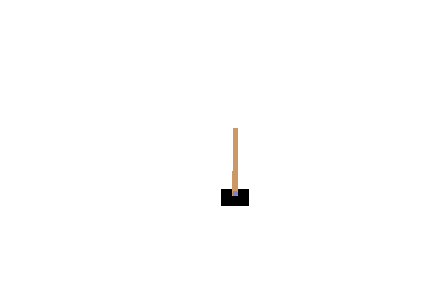
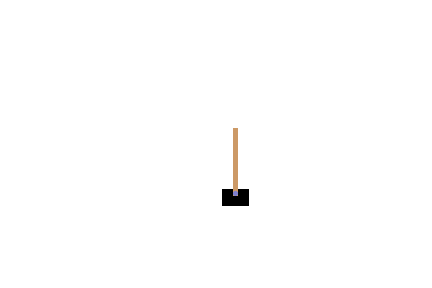
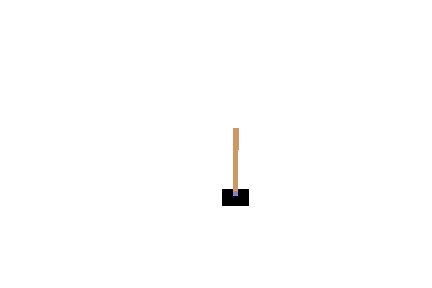
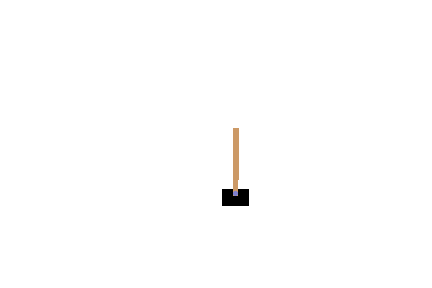
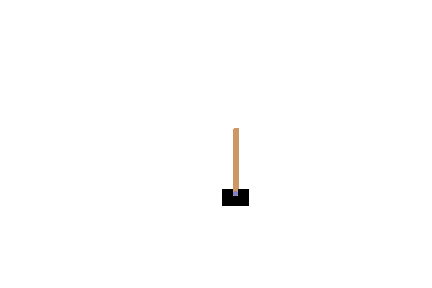
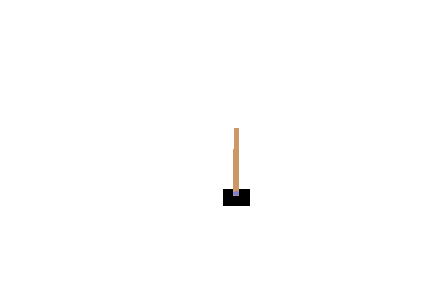
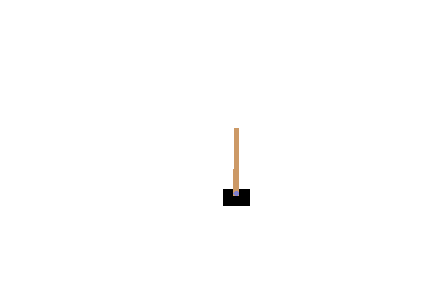
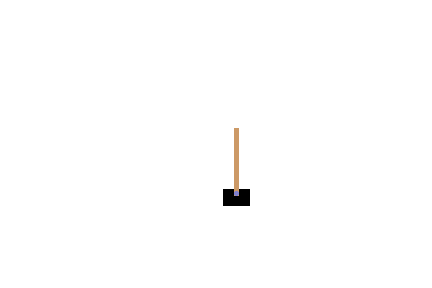
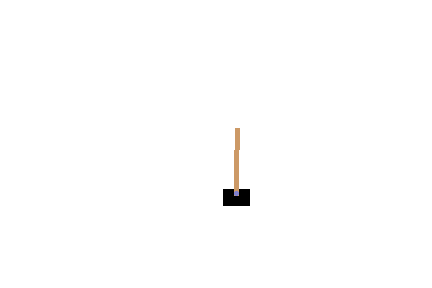
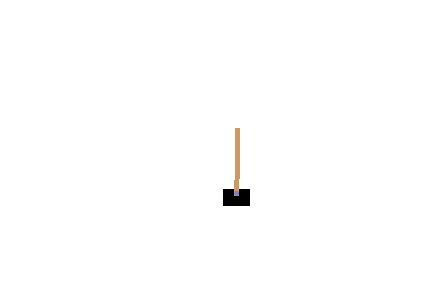
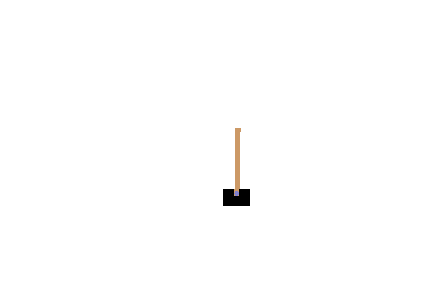
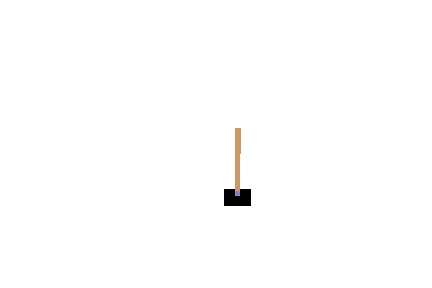
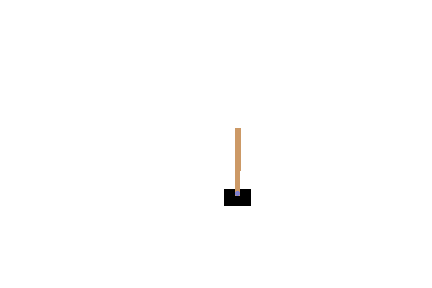
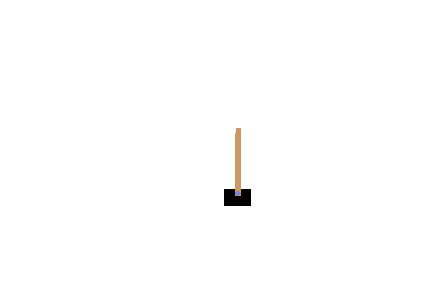
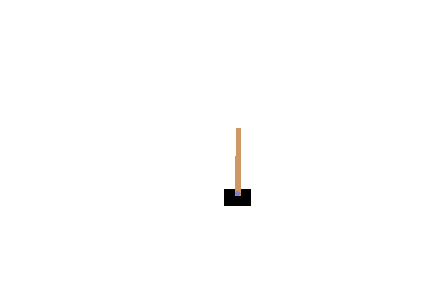
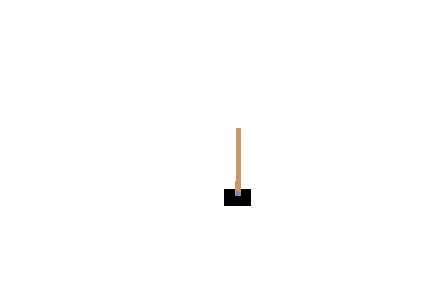
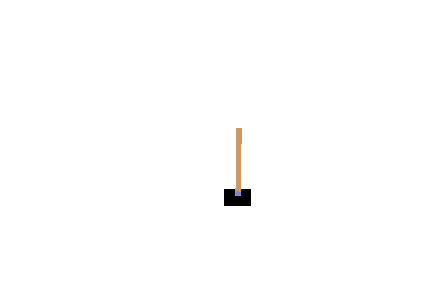
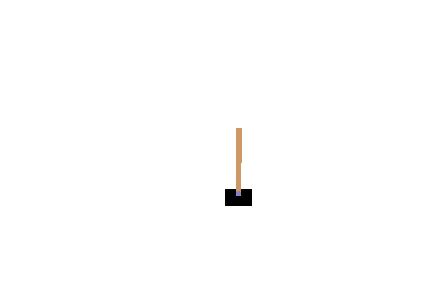
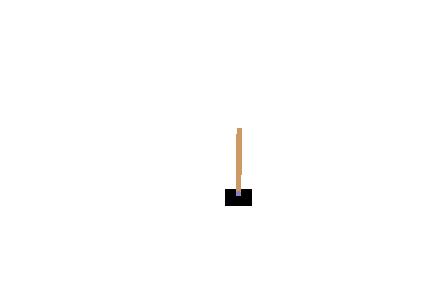
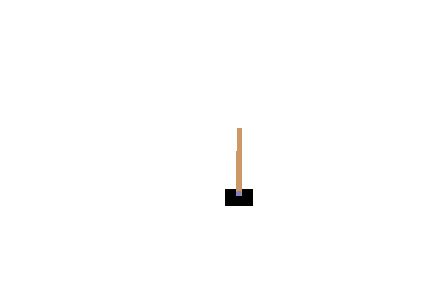
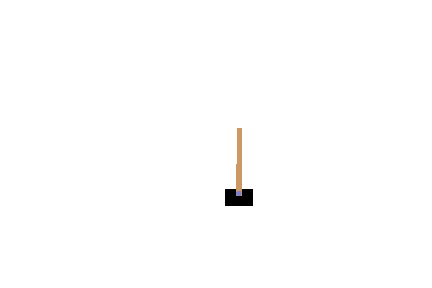
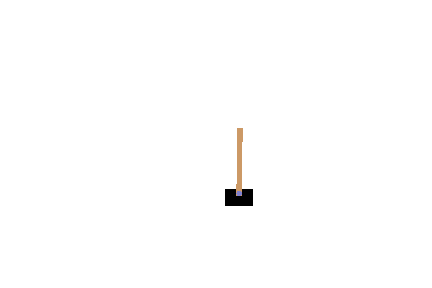
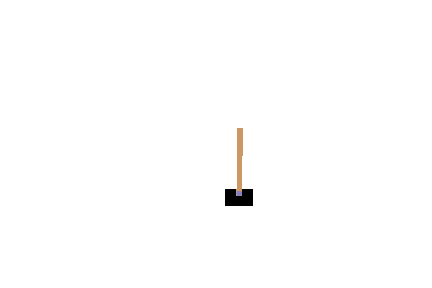
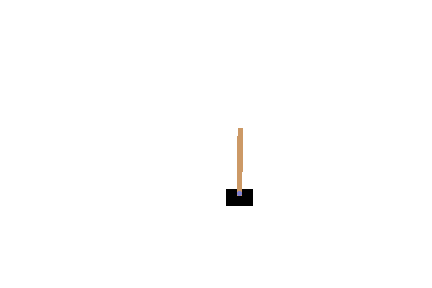
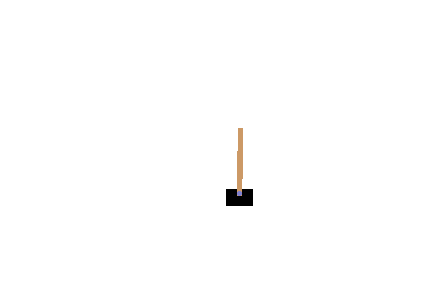
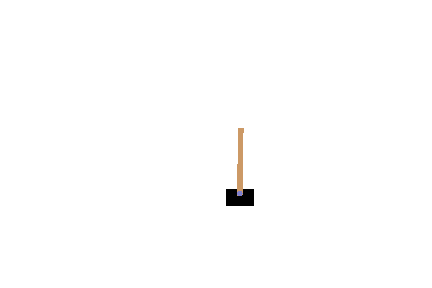
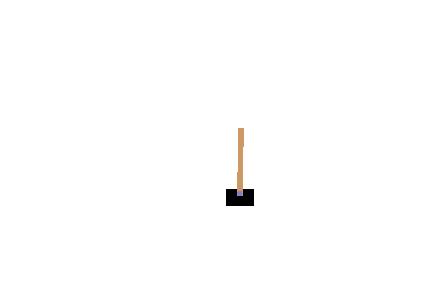
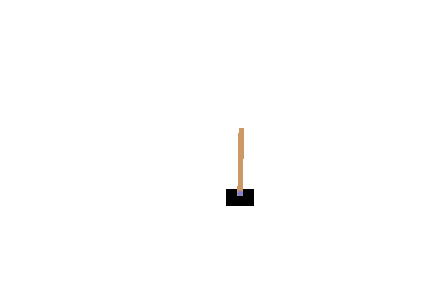
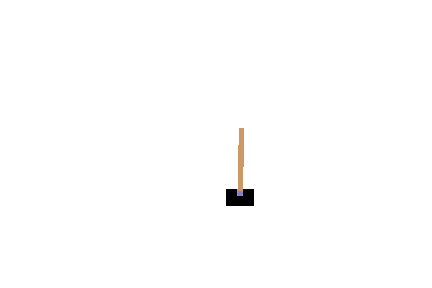
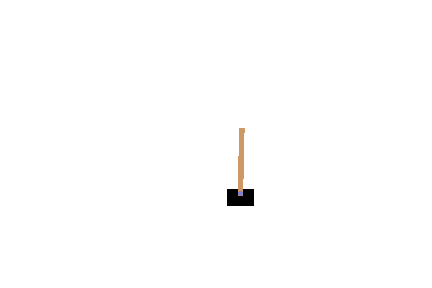
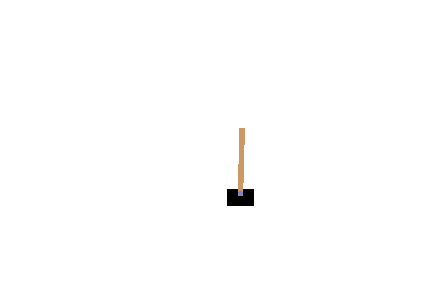
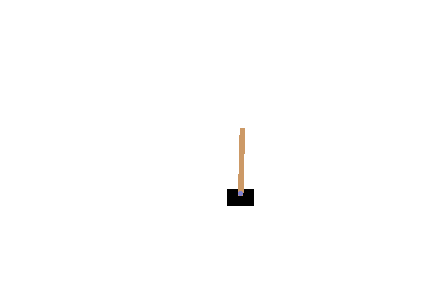
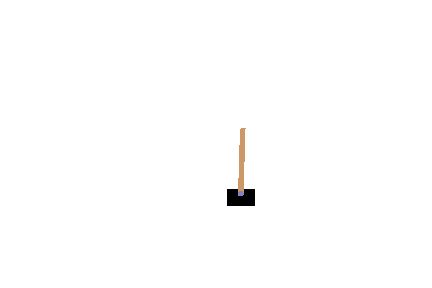
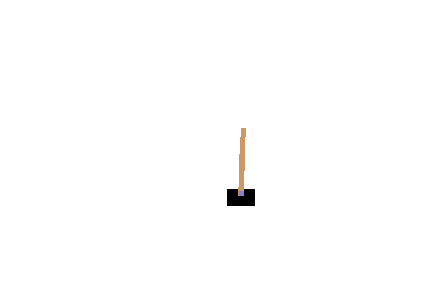
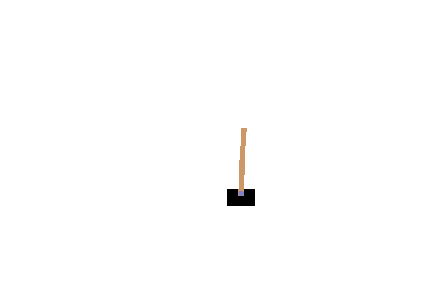
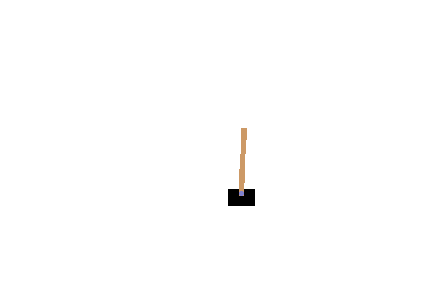
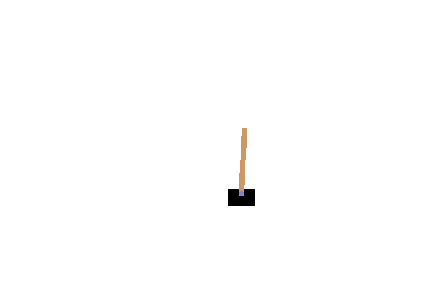
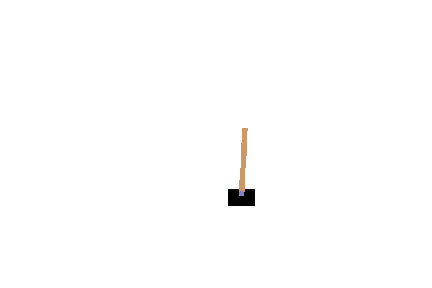
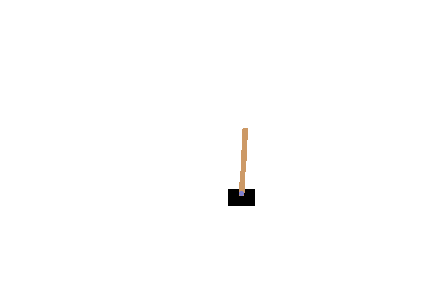
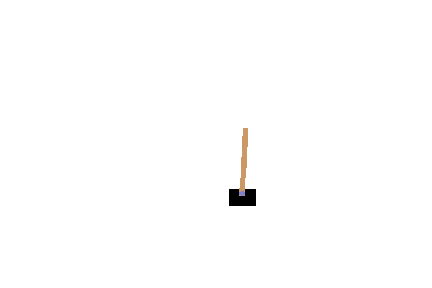
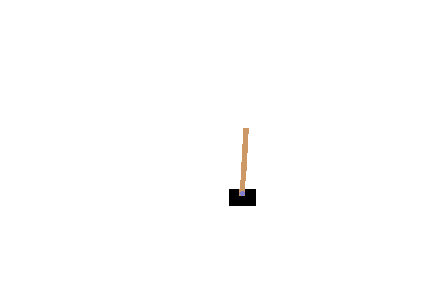
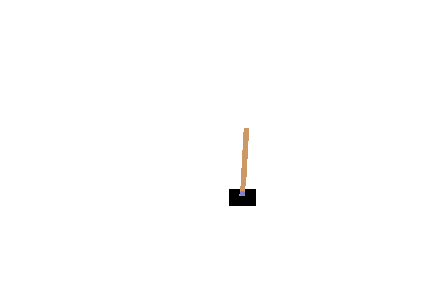
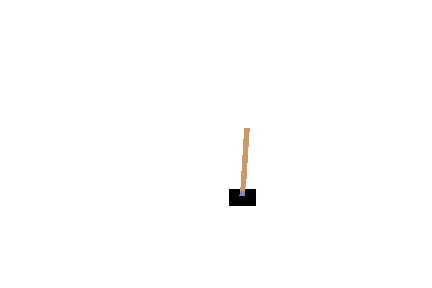
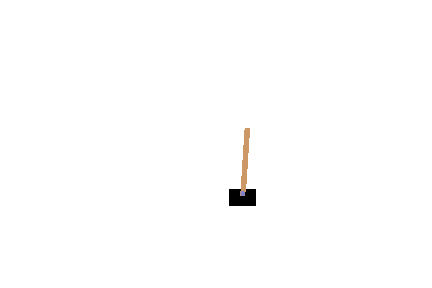
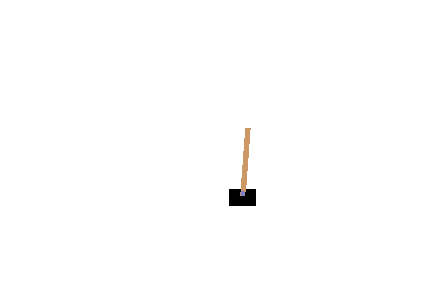
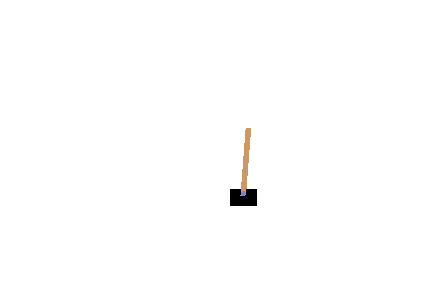
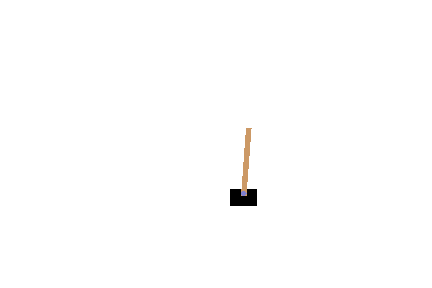
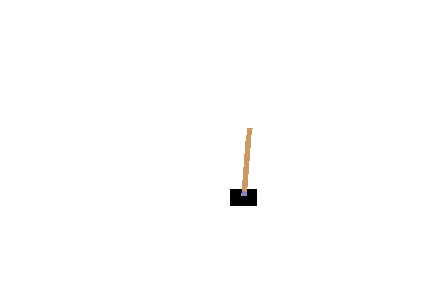
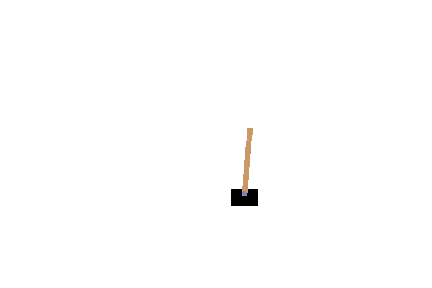
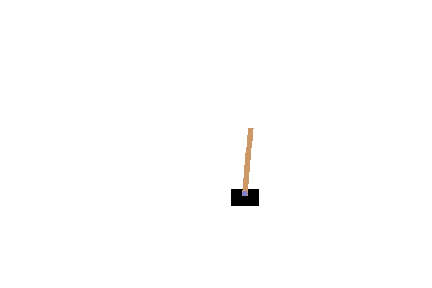
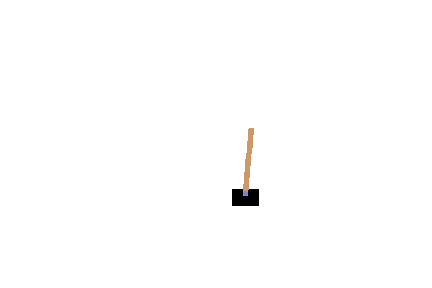
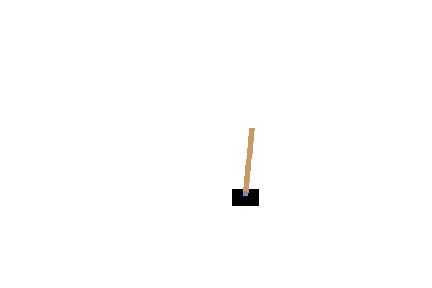
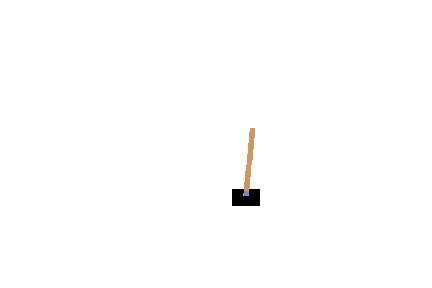
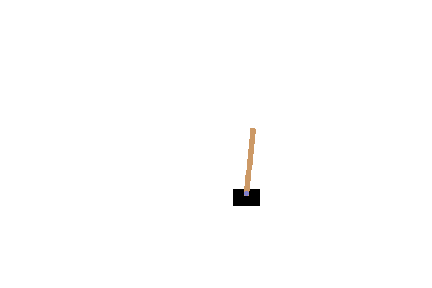
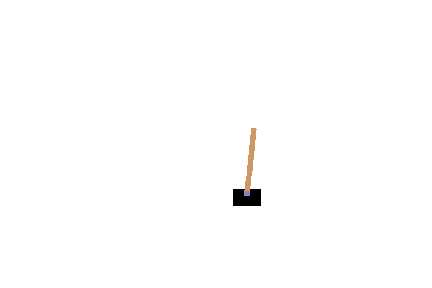
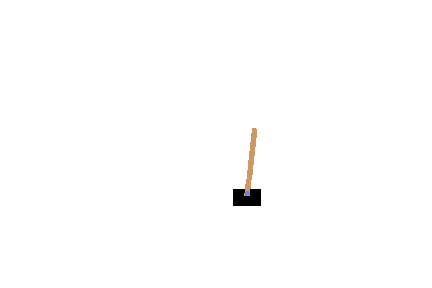
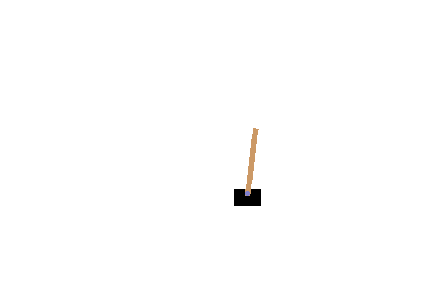
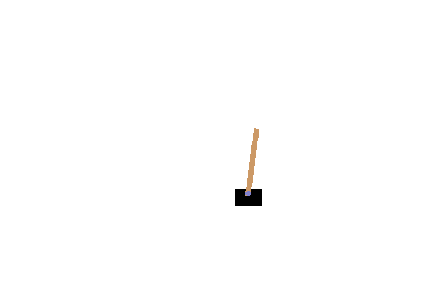
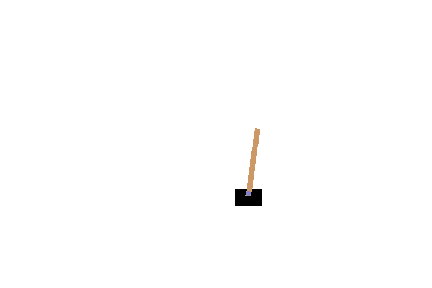
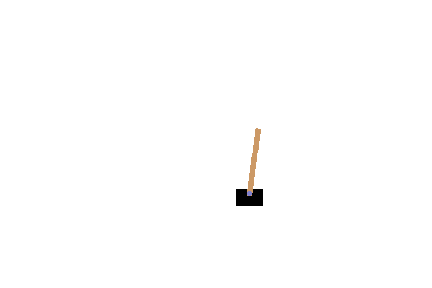
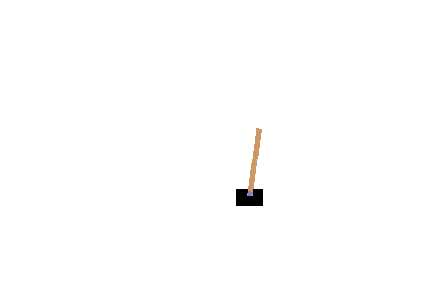
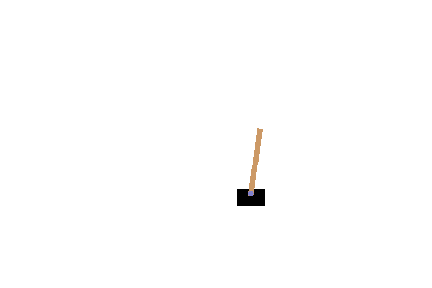
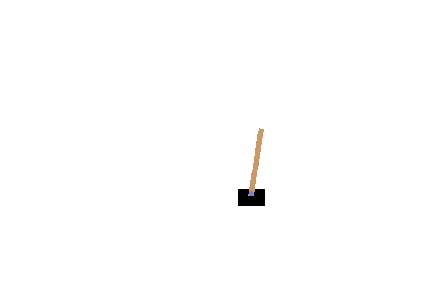
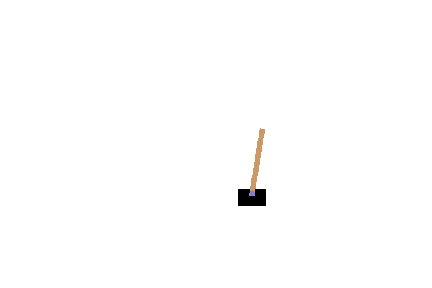
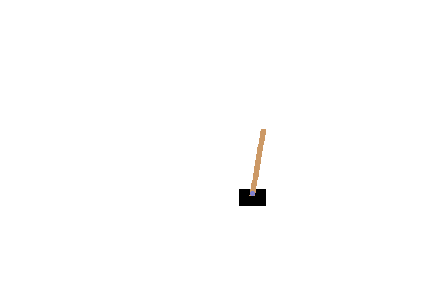
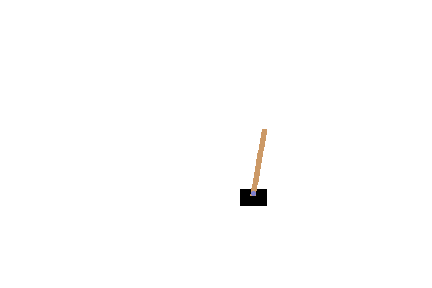
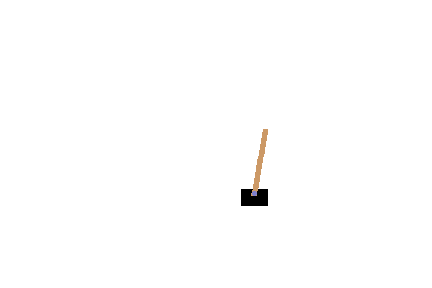
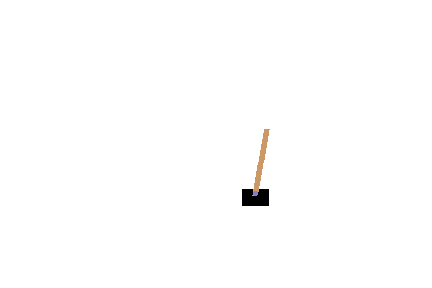
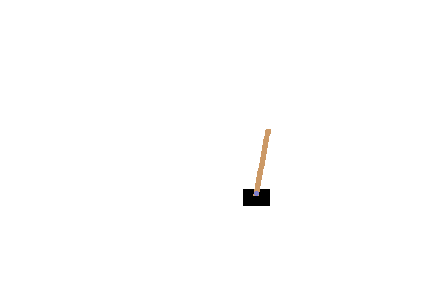
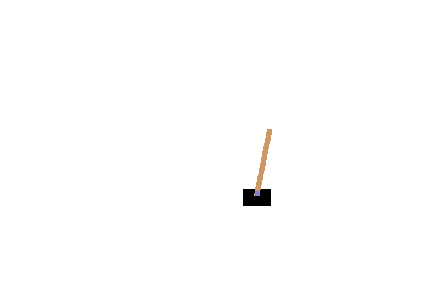
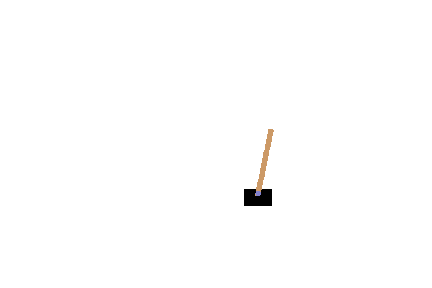
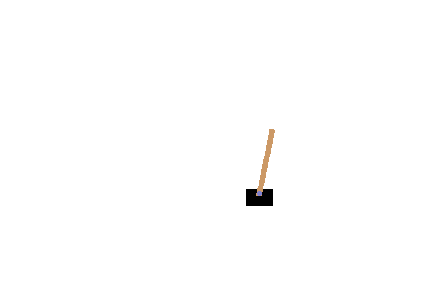

In [12]:
e.test(d)

In [10]:
cartpole()

NameError: name 'cartpole' is not defined

In [ ]:
class QLearningTF(BaseAgent):
    def __init__(self,epsilon=1.0, decay= 0.98, gamma=1.0, 
                 learning_rate=0.01, featurizer=None,scaler=None,use_bias = False):
        super(QLearningTF, self).__init__(gamma, 
                 learning_rate, featurizer,scaler,use_bias)
        tf.keras.backend.clear_session()
        self.name = "QLearningTF"
        self.epsilon = epsilon
        self.decay = decay
        self.original_configs = {"epsilon":self.epsilon,"decay":self.decay}
        
    def initialize_model(self,observation_space,action_space):
        self.epsilon = self.original_configs["epsilon"]
        self.decay = self.original_configs["decay"]
        self.observation_space = observation_space[0]
        self.action_space = action_space
        input_space = self.observation_space  
        if self.featurizer:
            input_space = self.featurizer.transform([np.ones(self.observation_space)]).flatten().shape[0]
        if self.use_bias:
            input_space += 1
        
        self.model["outputs"] = []
                
        for action in range(self.action_space):
            estim = LinearEstimatorTF(input_space=input_space,output_space=1)
            self.model["outputs"].append(estim)
        
                
        def mse_loss(model,predictions,targets):
            return tf.reduce_mean(tf.square(tf.subtract(predictions,targets))) + tf.add_n(model.losses)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        def train_step(model,inputs,targets):
            with tf.GradientTape() as tape:
                predictions = model(inputs)
                total_loss = mse_loss(model,predictions,targets)
            gradients = tape.gradient(total_loss,model.trainable_variables)
            optimizer.apply_gradients(zip(gradients,model.trainable_variables))
                
        self.model["loss"] = mse_loss
        self.model["training_op"] = train_step
        print("Model Created!")
    
    def update_hyper_params(self,episode):
        self.epsilon *= (self.decay**episode)
        
    def train_policy(self):
        return self.epsilon_greedy()
    
    def test_policy(self):
        return self.greedy()
    
    def epsilon_greedy(self):
        def act(obs):
            qvals = []
            for action in range(self.action_space):
                estimator = self.model["outputs"][action]
                qval = estimator(self.featurize_state(obs))
                qvals.append(qval)
            if np.random.random() < self.epsilon:
                return np.random.choice(self.action_space) , qvals
            return np.argmax(qvals) , qvals
        return act
                
    def greedy(self):
        def act(obs):
            qvals = []
            for action in range(self.action_space):
                estimator = self.model["outputs"][action]
                qval = estimator(self.featurize_state(obs))
                qvals.append(qval)
            return np.argmax(qvals) , qvals
        return act
    
    def train_iter(self,policy,action,values,obs,next_obs,reward,done):
        training_op = self.model["training_op"]
        next_action , next_qs = policy(next_obs)
        target = reward + self.gamma*np.max(next_qs)
        inp = self.featurize_state(obs)
        training_op(self.model["outputs"][action],inp,target)
        
    def train(self,env,episodes=200,early_stop=False,stop_criteria=20):
        prev_avg = -float('inf')
        orig_epsilon = self.epsilon
        bar = tqdm(np.arange(episodes),file=sys.stdout)
        policy = self.epsilon_greedy()
        criteria = 0 #stopping condition
        loss = self.model["loss"]
        training_op = self.model["training_op"]
        for i in bar:
            observation = env.reset()
            self.epsilon *= (self.decay**i)
            rewards = 0
            end = 0
            for t in range(10000):
                action , qvals = policy(observation)
                next_obs, reward, done, info = env.step(action)
                rewards += reward
                next_action , next_qs = policy(next_obs)
                target = reward + self.gamma*np.max(next_qs)
                inp = self.featurize_state(observation)
                training_op(self.model["outputs"][action],inp,target)
                end = t
                if done:
                    break
                observation = next_obs
                
            self.stats["num_steps"].append(end)
            self.stats["episodes"].append(i)
            self.stats["rewards"].append(rewards)
            avg = np.mean(self.stats["rewards"][::-1][:25])
            bar.set_description("Epsilon and reward {} : {}".format(self.epsilon,avg))
            
            if avg < prev_avg:
                criteria += 1
                
            if early_stop:
                if criteria >= stop_criteria:
                    break
                    
            prev_avg = avg
        return self.stats

In [ ]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
s = DQNTF(observation_space,action_space)
sstats_dict = s.train(env,episodes=100,early_stop=False,stop_criteria=20)

In [ ]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
s = QLearningTF(observation_space=observation_space,action_space=action_space,use_bias=True,featurizer=featurizer,scaler=scaler)
stats_dict = s.train(env,episodes=100,early_stop=False,stop_criteria=20)
plotting.plot_metrics(s.stats)

## DQN Torch

In [ ]:
def create_linear_torch(input_dims,output_dims,batch_norm=False):
    layers = []
    lin = torch.nn.Linear(input_dims,output_dims)
    layers.append(lin)
    if batch_norm:
        layers.append(torch.nn.BatchNorm1d(output_dims))
    return torch.nn.Sequential(*layers)

In [ ]:
class DQN(torch.nn.Module):
    def __init__(self,input_size,output_size):
        super(DQN, self).__init__()
        self.linear1 = create_linear(input_size,64)
        self.linear2 = create_linear(64,32)
        self.linear3 = create_linear(32,16)
        self.linear4 = torch.nn.Linear(16,output_size)
        
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        x = x.reshape(x.size(0), -1)
        x = F.softmax(x)
        return x

In [ ]:
class DQNTorch():
    def __init__(self, env, epsilon=1.0, decay= 0.98, gamma=1.0, 
                 learning_rate=0.01, featurize=False, use_bias = False):
        self.epsilon = epsilon
        self.decay = decay
        self.env = env
        self.action_space = env.action_space.n
        self.state_space = env.observation_space.shape[0]
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.featurize = featurize
        self.featurizer = None
        self.scaler = None
        self.model = {}
        self.use_bias = use_bias
        self.create_model()
        self.stats = {"rewards":[],"episodes":[],"num_steps":[]}
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        if self.featurize:
            scaled = self.scaler.transform([state])
            featurized = self.featurizer.transform(scaled)
            if self.use_bias:
                return np.concatenate([1],featurized[0])
            return featurized[0]
        if self.use_bias:
            return np.concatenate(([1],state))
        return state  
    
    def create_model(self):
        input_space = self.state_space    
        # featurizing code taken from https://github.com/dennybritz/reinforcement-learning/tree/master/FA
        # Used to convert a state to a featurizes represenation.
        # Use RBF kernels with different variances to cover different parts of the space
        if self.featurize:
            input_space = 400
            observation_examples = np.array([self.env.observation_space.sample() for x in range(10000)])
            self.scaler = sklearn.preprocessing.StandardScaler()
            self.scaler.fit(observation_examples)

            self.featurizer = sklearn.pipeline.FeatureUnion([
                    ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
                    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
                    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
                    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
                    ])
            self.featurizer.fit(observation_examples)
        if self.use_bias:
            input_space += 1
        self.model["optimizers"] = []
        self.model["output"] = DQN(input_size=input_space,output_size=self.action_space)
        
        self.model["loss"] = torch.nn.MSELoss()
        self.model["optimizer"] = torch.optim.Adam(params=self.model["output"].parameters(),
                                                   lr=self.learning_rate,weight_decay=0.0001)

        print("Model Created!")
    
    def epsilon_greedy(self):
        def act(obs):
            qvals = []
            func = self.model["output"]
            qvals = func(obs)
            if np.random.random() < self.epsilon:
                return np.random.choice(self.action_space) , qvals
            return np.argmax(qvals) , qvals
        return act
    
    def greedy(self):
        def act(obs):
            qvals = []
            func = self.model["output"]
            for action in range(self.action_space):
                W = self.model["Ws"][action]
                qval = func(obs,W)[0]
                qvals.append(qval)
            return np.argmax(qvals) , qvals
        return act
    
    def train(self,episodes=200,early_stop=False,stop_criteria=20):
        prev_avg = -float('inf')
        orig_epsilon = self.epsilon
        bar = tqdm(np.arange(episodes),file=sys.stdout)
        policy = self.epsilon_greedy()
        criteria = 0 #stopping condition
        loss_func = self.model["loss"]
        for i in bar:
            observation = env.reset()
            self.epsilon *= (self.decay**i)
            rewards = 0
            end = 0
            for t in range(10000):
                action , qvals = policy(observation)
                next_obs, reward, done, info = env.step(action)
                rewards += reward
                next_action , next_qs = policy(next_obs)
                target = reward + self.gamma*next_qs[next_action]
                                
                loss = loss_func(target.detach(),qvals[action])
                loss.backward()
                # Adjust weights & reset gradients
                end = t
                if done:
                    break
                observation = next_obs
                
            self.stats["num_steps"].append(end)
            self.stats["episodes"].append(i)
            self.stats["rewards"].append(rewards)
            avg = np.mean(self.stats["rewards"][::-1][:25])
            bar.set_description("Epsilon and reward {} : {}".format(self.epsilon,avg))
            
            if avg < prev_avg:
                criteria += 1
                
            if early_stop:
                if criteria >= stop_criteria:
                    break
                    
            prev_avg = avg
        return self.stats 

In [ ]:
done = False
for e in range(n_episodes): # iterate over new episodes of the game
    state = env.reset() # reset state at start of each new episode of the game
    state = np.reshape(state, [1, state_size])
    
    for time in range(5000):  # time represents a frame of the game; goal is to keep pole upright as long as possible up to range, e.g., 500 or 5000 timesteps
#         env.render()
        action = agent.act(state) # action is either 0 or 1 (move cart left or right); decide on one or other here
        next_state, reward, done, _ = env.step(action) # agent interacts with env, gets feedback; 4 state data points, e.g., pole angle, cart position        
        reward = reward if not done else -10 # reward +1 for each additional frame with pole upright        
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done) # remember the previous timestep's state, actions, reward, etc.        
        state = next_state # set "current state" for upcoming iteration to the current next state        
        if done: # episode ends if agent drops pole or we reach timestep 5000
            print("episode: {}/{}, score: {}, e: {:.2}" # print the episode's score and agent's epsilon
                  .format(e, n_episodes, time, agent.epsilon))
            break # exit loop
    if len(agent.memory) > batch_size:
        agent.replay(batch_size) # train the agent by replaying the experiences of the episode
    if e % 50 == 0:
        agent.save(output_dir + "weights_" + '{:04d}'.format(e) + ".hdf5")